In [0]:
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
import math
import numpy as np
import time
import os
import cv2
from google.colab.patches import cv2_imshow
import zipfile
import tarfile
from collections import namedtuple
from google.colab.patches import cv2_imshow
from xml.dom import minidom
import pandas as pd
from google.colab import files
import csv


In [2]:
!git clone 'https://github.com/UralmashFox/CV_Project'
%cd CV_Project
df1 = pd.read_csv('book.csv', na_values='-', sep = ';') 
df1 = df1.fillna(0)
!pip install patool
import patoolib
patoolib.extract_archive("pngs.rar", outdir="/content")
%cd ..


Cloning into 'CV_Project'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 106 (delta 4), reused 1 (delta 0), pack-reused 81
Receiving objects: 100% (106/106), 2.51 MiB | 23.15 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/CV_Project
     |████████████████████████████████| 81kB 2.3MB/s 
patool: Extracting pngs.rar ...
patool: running /usr/bin/unrar x -- /content/CV_Project/pngs.rar
patool:     with cwd='/content'
patool: ... pngs.rar extracted to `/content'.
/content


In [3]:
import nltk
nltk.download('punkt')
from nltk import tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
 def to_BoWs(sentances):
  i = 0
  BoW = []
  all_BoW = []
  for sentance in sentances:
    words = sentance.split()
    BoW = []
    for word in words:
      word = word.lower()
      word = word.replace('.', '')
      word = word.replace('!', '')
      word = word.replace(',', '')
      word = word.replace('-', '')
      word = word.replace(':', '')
      BoW.append(word)
    all_BoW.append(BoW)
  return(all_BoW)
  

In [0]:
 def get_info (all_BoW): 
  obj = df1.obj
  code = df1.code
  flip = df1.flip
  axis_x = df1.x
  axis_y = df1.y
  all_ID = []
  true_ID = []
  all_flip = []
  all_y = []
  all_x = []

  for BoW in all_BoW:
    num = 0
    val = 0
    ID = []
    y = []
    x = []
    flips = []
    x_h = 0
    y_h = 0
    for word in BoW:
      for index, row in enumerate(obj):
        if word == row:
          try:
            val = int(code[index])
            num = num+val
          except:
            ID.append(code[index])
            flips.append(flip[index])
            try:
              x.append(float(axis_x[index].replace(',', '.')))
              y.append(float(axis_y[index].replace(',', '.')))
            except:
              if isinstance(axis_x[index], int): x.append(axis_x[index])
              else: x.append(x[len(x)-1])
              if isinstance(axis_y[index], int): y.append(axis_y[index])
              else: y.append(y[len(y)-1])

    ID.append(num)
    all_x.append(x)
    all_y.append(y)
    all_ID.append(ID)
    all_flip.append(flips)
  return(all_ID, all_flip, all_x, all_y)
  

In [0]:
 def real_ID(all_ID):
  trueID = []
  for IDs in all_ID:
    ident = []
    for id in IDs:
      if (id == 'hb0') or (id == 'hb1'):
        true_id = str(id) + '_' + str(IDs[len(IDs)-1]) + 's'
        ident.append(true_id)
      elif not isinstance(id, int):
        true_id = id
        ident.append(true_id)
    trueID.append(ident)
  return(trueID)
  

In [0]:
def to_background(background, image, x,y):
  hi, wi, ci = image.shape
  hb, wb, cb = background.shape
  for w in range(0, wi):
    for h in range (0, hi):
      if not (image[h][w][3] == 0 ):
        background[int(h+hb*y), int(x*wb+w)] = image[h][w]
  return(background)
  

In [0]:
def to_one_array(images, flips, all_x, all_y):
  back_i = []
  back_f = []
  back_x = []
  back_y = []

  for image in images:
    for img in image:
      back_i.append(img)
  for flip in flips:
    for flp in flip:
      back_f.append(flp)
  for X in all_x:
    for x in X:
      back_x.append(x)
  for Y in all_y:
    for y in Y:
      back_y.append(y)
  return(back_i, back_f, back_x, back_y)
  

In [0]:
 def text2img(all_ID, all_flip, all_x, all_y): 
  background =  cv2.imread('background.png', cv2.IMREAD_UNCHANGED)
  images, flips, x, y = to_one_array(trueID, all_flip, all_x, all_y)
  # print(images, flips, x, y)
  for IMG in images:
    img = IMG + '.png'
    image = cv2.imread(img, cv2.IMREAD_UNCHANGED)
    if images.index(IMG) < len(images)-1:
      if x[images.index(IMG)+1] == x[images.index(IMG)] and y[images.index(IMG)+1] == y[images.index(IMG)]:
        x[images.index(IMG)+1] = x[images.index(IMG)+1] + x[images.index(IMG)]*3/30
        y[images.index(IMG)+1] = y[images.index(IMG)+1]-image.shape[0]/2500
      # print(x[images.index(IMG)+1] == x[images.index(IMG)] and y[images.index(IMG)+1] == y[images.index(IMG)])
    if flips[images.index(IMG)]:
      image = cv2.flip(image, 1)
    try:
      background = to_background(background, image, x[images.index(IMG)], y[images.index(IMG)])
    except:
      image = cv2.resize(image, (int(image.shape[0]/4), int(image.shape[1]/2)))
      background = to_background(background, image, x[images.index(IMG)], y[images.index(IMG)])
    # cv2_imshow(image)
  return(background)
  

In [0]:
%matplotlib inline
from IPython.display import clear_output
import argparse
from collections import defaultdict
from scipy import stats

In [0]:
def read_and_resize(filename, fx = 1.0, fy = 1.0):
  """
  this function convert images to the standart form
  """

  img_result = cv2.cvtColor(filename, cv2.COLOR_BGR2RGB)

  if fx != 1.0 and fy != 1.0:
    img_result = cv2.resize(img_result, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
  return img_result
  

In [0]:
def to_cartoonize(image):
    """
    convert image into cartoon-like image
    """

    output = np.array(image)
    x, y, c = output.shape

    for i in range(c):
        output[:, :, i] = cv2.bilateralFilter(output[:, :, i], 5, 50, 50)
    edge = cv2.Canny(output, 100, 200)
    output = cv2.cvtColor(output, cv2.COLOR_RGB2HSV)

    hists = []
    #H
    hist, _ = np.histogram(output[:, :, 0], bins=np.arange(180+1))
    hists.append(hist)
    #S
    hist, _ = np.histogram(output[:, :, 1], bins=np.arange(256+1))
    hists.append(hist)
    #V
    hist, _ = np.histogram(output[:, :, 2], bins=np.arange(256+1))
    hists.append(hist)

    C = []
    for h in hists:
        C.append(to_choose_best_k(h))
    output = output.reshape((-1, c))

    for i in range(c):
        channel = output[:, i]
        index = np.argmin(np.abs(channel[:, np.newaxis] - C[i]), axis=1)
        output[:, i] = C[i][index]
    output = output.reshape((x, y, c))
    output = cv2.cvtColor(output, cv2.COLOR_HSV2RGB)
    contours, _ = cv2.findContours(edge,
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(output, contours, -1, 0, thickness=1)
    return output


In [0]:
def to_choose_best_k(hist):
    """
    choose the best K for k-means and get the centroids
    """

    alpha = 0.5              # p-value
    min_group_size = 20      # minimun group size
    C = np.array([128])

    while True:
        C, groups = to_update_C(C, hist)
        # starting increase K
        new_C = set()

        for i, indice in groups.items():
            # not ehough values in group => don't separate centroid
            if len(indice) < min_group_size:
                new_C.add(C[i])
                continue
            # checking is the value in normal distribution of contour
            z, p_value = stats.normaltest(hist[indice])

            if p_value < alpha:
                # not a normal dist, seperate
                left = 0 if i == 0 else C[i-1]
                right = len(hist)-1 if i == len(C)-1 else C[i+1]
                delta = right-left

                if delta >= 3:
                    c1 = (C[i]+left)/2
                    c2 = (C[i]+right)/2
                    new_C.add(c1)
                    new_C.add(c2)
                else:
                    # if value is not in normal distribution, go to next one 
                    new_C.add(C[i])
            else:
                # if value is in normal distribution, don't separate
                new_C.add(C[i])
                
        if len(new_C) == len(C):
            break
        else:
            C = np.array(sorted(new_C))
    return C
    

In [0]:
def to_update_C(C, hist):
    """
    update centroids as long as they stop chainging
    """

    while True:
        groups = defaultdict(list)
        #assign pixels
        for i in range(len(hist)):
            if hist[i] == 0:
                continue
            d = np.abs(C-i)
            index = np.argmin(d)
            groups[index].append(i)

        new_C = np.array(C)
        for i, indice in groups.items():
            if np.sum(hist[indice]) == 0:
                continue
            new_C[i] = int(np.sum(indice*hist[indice]) / np.sum(hist[indice]))
        if np.sum(new_C-C) == 0:
            break
        C = new_C
    return C, groups


In [0]:
def to_show_in_row(list_of_images, titles = None, disable_ticks = False):
  """
  this function takes images before and after cartoonize
  and compares them to let you see the differnce 
  """

  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()
  

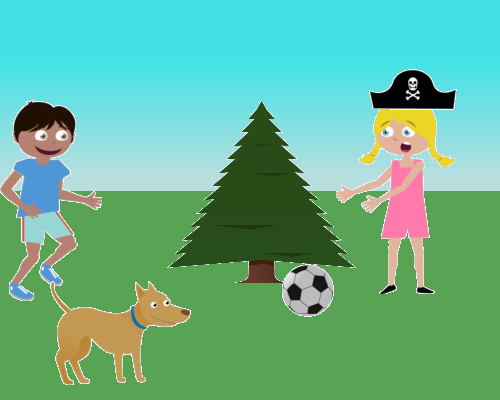

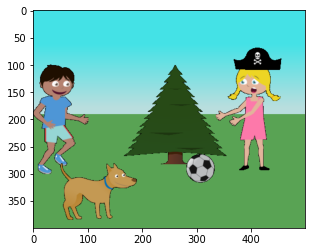

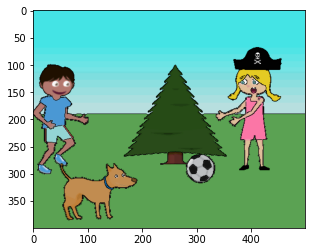

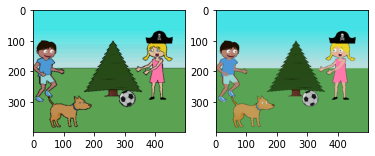

In [19]:
text = "It was cloudy. Smiling Mike was running near the tree and playing soccer. There was a dog and Jenny was worried, she was a pirate"
#step by step: -1- split sentances -2- split words -3- find IDs, coordinates, flips -4- find name of img files -5- images to background
sentances = tokenize.sent_tokenize(text)
all_BoW = to_BoWs(sentances)
all_ID, all_flip, all_x, all_y = get_info(all_BoW)
trueID = real_ID(all_ID)
final_image = text2img(all_ID, all_flip, all_x, all_y)
#shows image from text
cv2_imshow(final_image)
#shows resized image before cartoonizer
image_to_cartoonize = read_and_resize(final_image)
plt.imshow(image_to_cartoonize)
plt.show()
#shows image after cartoonizer
result_image = to_cartoonize(image_to_cartoonize)
plt.imshow(result_image)
plt.show()
#shows both images before and after cartoonizer to compare
to_show_in_row([result_image, image_to_cartoonize])